In [2]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
import gc

root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.join(root,'imStat','code'))
import utils
import model_src
import other_model_code

sys.path.append(os.path.join(root,'texture-synthesis-portilla-simoncelli'))
import steerable_pyramid

import pyrtools as pt

In [4]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [5]:
# Loading a set of actual images

from scipy import io
import h5py

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = io.loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from utils import load_nsd

n_samples = 5000
trn_stim_data = load_nsd.image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data

[h5py._conv] 2021-06-16 00:37:27,463 DEBUG 47 Creating converter from 7 to 5
[h5py._conv] 2021-06-16 00:37:27,464 DEBUG 47 Creating converter from 5 to 7
[h5py._conv] 2021-06-16 00:37:27,465 DEBUG 47 Creating converter from 7 to 5
[h5py._conv] 2021-06-16 00:37:27,466 DEBUG 47 Creating converter from 5 to 7


block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


In [7]:
from other_model_code import nsd_utils as n
from other_model_code import gfb_utils as g
# defining the "nsd index" of the trials we're using here, need this for the older version of my filtering code.
nsd_inds = n.get_nsd_inds_by_subject(subj=subject, trial_inds=np.arange(0,n_samples))
image_ind=0
nsd_ind = nsd_inds[image_ind]
# gather metadata for these images and load the one of interest
nsd_brick_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5'

with h5py.File(nsd_brick_file, "r") as f:
    nsd_im = f['imgBrick'][nsd_ind,:,:,:] 
nsd_im = g.preproc_for_filt(nsd_im, desired_size = (227,227), grayscale=True)

In [8]:
# Parameters

from model_src import rf_grid

n_ori=8;
n_sf=3

cyc_per_stim = rf_grid.logspace(n_sf)(3., 72.)
# cyc_per_stim = rf_grid.logspace(n_sf)(20,72)

freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [9]:
## First level features

gc.collect()
torch.cuda.empty_cache()

n_images= 50
sample_batch_size=1

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_spat(bank, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

maps_spat = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

print(np.shape(maps_spat))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

took 2.61 s to make filters
(50, 227, 227, 24)
total time is 15.86 s


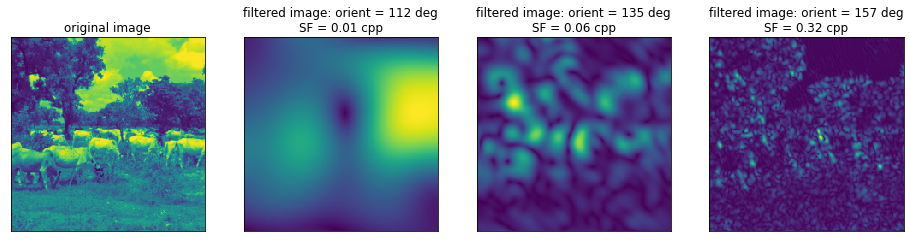

In [187]:
# Plotting first level feature maps

image_ind = 0

orient_labs = bank.orient_labs
a,orient_ind_list = np.unique(orient_labs,return_inverse=True)
freq_labs = bank.freq_labs
a,freq_ind_list = np.unique(freq_labs,return_inverse=True)

nFilts = len(orient_labs)

# ori2plot = (np.array([90,90,90])/5).astype('int')
# sf2plot = np.array([2,6,10]).astype('int')
ori2plot = (np.array([5,6,7])).astype('int')
sf2plot = np.array([0,1,2]).astype('int')

plt.figure(figsize=(16,16));

plt.subplot(1,4,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in  range(len(sf2plot)):
    
    ff = np.where(np.logical_and(orient_ind_list==ori2plot[ii], freq_ind_list==sf2plot[ii]))[0][0];
   
    plt.subplot(1,4,2+ii)
    plt.pcolormesh(maps_spat[image_ind,:,:,ff])
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])
   

In [201]:
pyr = pt.pyramids.SteerablePyramidFreq(image)

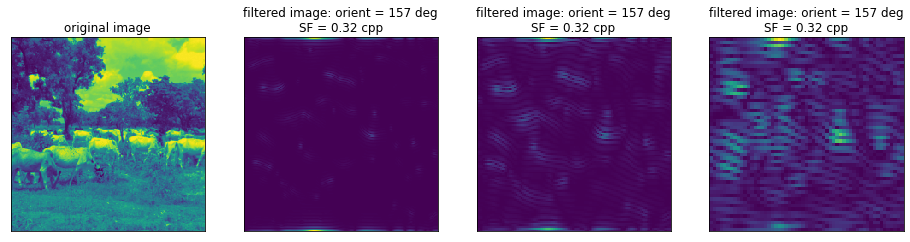

In [207]:
plt.figure(figsize=(16,16));

plt.subplot(1,4,1)
plt.pcolormesh(images[image_ind,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

sf_bands = [0,1,2]
ori_bands = [2,2,2]

for ii in range(len(sf_bands)):
    
    fmap = np.abs(pyr.pyr_coeffs[(sf_bands[ii],ori_bands[ii])])
    
    plt.subplot(1,4,2+ii)
    plt.pcolormesh(fmap)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ff],freq_labs[ff]))
    plt.xticks([])
    plt.yticks([])




In [203]:
pyr.pyr_coeffs.keys()

dict_keys(['residual_highpass', (0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), 'residual_lowpass'])